### （完成版で予定している）前提条件

・対数正規分布に従うような「企業価値」の変動（株式市場にとっては外生的な変動）

・「企業価値」に比例した「均衡」株価

・１エージェントが採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは各エージェントごとに独自に振動する。収益率の低いエージェントほど他エージェントの真似をして戦略やパラメータを変更する傾向を持つ。

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ

・配当（企業価値の一定割合）と税（利益の一定割合）と非金融所得（外生的、一定、全エージェント）の導入

・時間１が四半期あるいは１年程度のスパンをイメージする


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [1]:
using StatsPlots
using Random
using Statistics

In [2]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオに占める預金の割合の目標, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオに占める預金の割合の目標, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    purchase_cost
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業価値
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 0.05, 2.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.05*firms[i].hiddenCorporateValue + 0.95*estimated_value) * exp(0.1*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        if agent.total_assets_log[end] <= 0
            agent.portfolio_target[1:2] = [0,0]
            continue
        end
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j, all_marketCap_sum)
    lst = []
    marketCap, mean_amp = 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        fundamentals = agent.fundamentals[i]
        push!(lst, (marketCap/fundamentals, i))    #   marketCap/fundamentalsが小さいほど買いたい、大きいほど売りたい
        mean_amp += marketCap/fundamentals
    end
    mean_amp /= size(firms)[1]
    sell, buy = [], []
    #   全部売り候補に入れて、ポートフォリオ配分目標に至るまで買い候補に入れて、その差量を本チャンの売買リストに加える
    #   持ってる株をすべて仮売り。
    for (i,q) in enumerate(agent.sharesQuantity)
        if q > 0.0
            p = 0.5*mean_amp*agent.fundamentals[i]/firms[i].stockQuantity + 0.5*firms[i].stockPrice
            push!(sell, (i, p, q))
        end
    end
    #   ポートフォリオ配分目標に達するまで仮買い。
    sort!(lst)
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    counter = 0
    while counter < Integer(agent.params[end])
        for k in 1:size(lst)[1]
            _, i = lst[k]
            if rand()*(1.0 - k/size(lst)[1]) < firms[i].marketCapitalization/all_marketCap_sum   #   規模の大きい企業ほど買いやすいように、割安判断をした企業ほど買いやすいようにする
                allocations_lst[i] += agent.portfolio_target[2]/agent.params[end]
                counter += 1
                if counter == Integer(agent.params[end])
                    break
                end
            end
        end
    end
    for k in 1:size(lst)[1]
        _, i = lst[k]
        if allocations_lst[i] == 0.0
            continue
        end
        p = 0.5*mean_amp*agent.fundamentals[i]/firms[i].stockQuantity + 0.5*firms[i].stockPrice
        q = allocations_lst[i]/p
        push!(buy, (i, p, q))
    end
    #   注文の決定
    going_to_buy_price = 0.0
    for (ib, pb, qb) in sell
        q, p = qb, pb
        for (is, ps, qs) in buy
            if ib == is
                q -= qs
                if q < 0.0
                    p = ps
                end
                break
            end
        end
        if q > 0
            push!(firms[ib].sell_offers, (p, q, j))
        elseif q < 0
            going_to_buy_price += p*(-q)
            if going_to_buy_price > agent.money
                continue
            end
            push!(firms[ib].buy_offers, (p, -q, j))
        end
    end
end
function chart_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    #   売り
    for (i, q) in enumerate(agent.sharesQuantity)
        if q == 0.0
            continue
        end
        x1, x2, x3, x4, x5, x6 = firms[i].stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p < β1
            push!(sell, (p,i))
        end
    end
    marketCap_sum = 0.0
    sell_2 = []
    for (p, i) in sell
        if agent.money < 0.0
            p = 0.0
        end
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if price > 0.0 && quantity > 0.0
            push!(sell_2, (p, i))
            marketCap_sum += firms[i].marketCapitalization
        end
    end
    going_to_sell_price = 0.0
    for (p, i) in sell_2
        if agent.money < 0.0 && p > 0.0
            p = 0.0
        end
        price = (1+p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        if rand() < firms[i].marketCapitalization/marketCap_sum
            going_to_sell_price += price * quantity
            push!(firms[i].sell_offers, (price, quantity, j))
        end
    end
    #   買い
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = α0 + α1*(x2-x1)/x1 + α2*(x3-x2)/x2 + α3*(x4-x3)/x3 + α4*(x5-x4)/x4 + α5*(x6-x5)/x5
        if p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    if size(buy)[1] > Integer(agent.params[end])
        buy = buy[end-Integer(agent.params[end])+1:end]
    end
    marketCap_sum = 0.0
    for (_, i) in buy
        marketCap_sum += firms[i].marketCapitalization
    end
    allocations_lst = [0.0 for _ = 1:size(firms)[1]]
    buy_target = agent.money + going_to_sell_price - agent.portfolio_target[1]
    if buy_target <= 0.0
        return nothing
    end
    for (_, i) in buy
        allocations_lst[i] = buy_target*firms[i].marketCapitalization/marketCap_sum
    end
    for (p, i) in buy
        price = (1+p)*firms[i].stockPrice
        if price <= 0.0
            continue
        end
        quantity = allocations_lst[i]/price
        push!(firms[i].buy_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms, all_marketCap_sum)
    for firm in firms
        firm.buy_offers, firm.sell_offers = [], []
    end
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j, all_marketCap_sum)
        elseif agent.strategy == "chart"
            chart_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents, income)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1] - income)/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            if jb < 0   #   企業自身からのオファー
                firms[-jb].stockQuantity -= trading_q
            else
                agents[jb].purchase_cost[i] = (agents[jb].purchase_cost[i]*agents[jb].sharesQuantity[i] + trading_p*trading_q)/(agents[jb].sharesQuantity[i] + trading_q)
                agents[jb].sharesQuantity[i] += trading_q
                agents[jb].money -= trading_p*trading_q
            end
            if js < 0
                firms[-js].stockQuantity += trading_q
            else
                agents[js].sharesQuantity[i] -= trading_q
                tax, tax_rate = 0.0, 0.2
                if agents[js].purchase_cost[i] < trading_p
                    tax = tax_rate*trading_q*(trading_p - agents[js].purchase_cost[i])
                end
                agents[js].money += trading_p*trading_q - tax
            end
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
        push!(firm.stockQuantityLog, firm.stockQuantity)
    end
end
function update_strategy(agents)
    if size(agents[1].total_assets_log)[1] < 10
        return nothing
    end
    A = Integer(size(agents)[1])
    for agent in agents
        teacher = rand(1:A)
        t0, t1 = agent.total_assets_log[end-9], agent.total_assets_log[end]
        if rand() < 0.01 - 0.01*(t1 - t0)/t0
            new_strategy = deepcopy(agents[teacher].strategy)
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
        if rand() < 0.001
            if agent.strategy == "chart"
                agent.strategy = "fundamentals"
                agent.params = [0.9, 5]
            else
                agent.strategy = "chart"
                agent.params = [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5]
            end
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "chart"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] = (agent.params[3:7] .- sum(agent.params[3:7])/5)/(std(agent.params[3:7])*sqrt(5))
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function update_marketCapitalization(firms)
    for firm in firms
        firm.marketCapitalization = firm.stockPrice*firm.stockQuantity
    end
end
function get_income(agents, income)
    for agent in agents
        agent.money += income
    end
end
function get_dividend(agents, firms)
    Π = 0.2
    payout_ratio = 0.35
    for agent in agents
        for (i, q) in enumerate(agent.sharesQuantity)
            if q > 0.0
                dividend = q/firms[i].stockQuantity * Π*payout_ratio*firms[i].hiddenCorporateValue
                agent.money += dividend
            end
        end
    end
end
function cal_all_marketCap_sum(firms)
    all_marketCap_sum = 0.0
    for firm in firms
        all_marketCap_sum += firm.marketCapitalization
    end
    return all_marketCap_sum
end
function share_buy_back_and_share_issue_offer(firms)
    for (i, firm) in enumerate(firms)
        t = rand()
        if t < 0.1
            quantity = 0.05*firm.stockQuantity
            price = 0.95*firm.stockPrice
            push!(firm.buy_offers, (price, quantity, -i))
        elseif t > 0.9
            quantity = 0.05*firm.stockQuantity
            price = 1.05*firm.stockPrice
            push!(firm.sell_offers, (price, quantity, -i))
        end
    end
end
function run_one_term(agents, firms, income)
    all_marketCap_sum = cal_all_marketCap_sum(firms)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms, all_marketCap_sum)
    share_buy_back_and_share_issue_offer(firms)
    trade_matching(agents, firms)
    get_dividend(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents, income)
    get_income(agents, income)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
    update_marketCapitalization(firms)
end
function f(t)
    return 2^(0.01*t)
end

f (generic function with 1 method)

In [3]:
N, M = 10^5, 10^1 #   エージェント数, 株式会社数
init_stock_quantity, init_stock_price = 100.0, 1.0
init_money = init_stock_quantity*init_stock_price*M/N * 9.0

agents = [
    Agent(
        "chart",
        init_money,
        [init_stock_quantity/N for _ = 1:M],
        [init_stock_quantity*init_stock_price/N for _ = 1:M],
        [init_money/0.9],
        [0.9, 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, 0.1*init_money],
        [1.0 for _ = 1:M],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [init_stock_quantity/N for _ = 1:M],
            [init_stock_quantity*init_stock_price/N for _ = 1:M],
            [init_money/0.9],
            [0.9, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, 0.1*init_money],
            [1.0 for _ = 1:M],
            0.0
        )
    )
end

σ_r, σ, μ = 0.2, 2.0, log(100.0)
σ_p = sqrt(σ^2 + σ_r^2)
x = [μ for _ = 1:M]
for t = 1:10^3
    for i = 1:M
        x[i] = exp((log(x[i]) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
firms = [
    Firm(
        init_stock_price,
        init_stock_quantity,
        [init_stock_price],
        [init_stock_quantity],
        init_stock_price*init_stock_quantity,
        x[i],   #   元init_stock_price*init_stock_quantity
        [],
        [],
    ) for i = 1:M
];

In [4]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

9000.000000010426

In [5]:
T = 10^3
income_lst = [0.0002*init_money for _ = 1:T]
#income_lst = [0.0002*init_money*f(t) for t = 1:T] 
#   income=constantだと、金融市場の規模が継続的に大きく（小さく）ならないためか、
#   適応の結果ポートフォリオ配分目標に占める預金の割合がとても大きくなる。そして売買が減り、値動きが激減する
@time for t = 1:T
    income = income_lst[t]
    run_one_term(agents, firms, income)
    if t % (T//100) == 0
        print("#")
    end
    if t % (T//10) == 0
        println()
    end
end

##########
##########
##########
##########
##########
##########
##########
##########
##########
##########
19895.825240 seconds (98.94 G allocations: 2.117 TiB, 16.56% gc time, 0.03% compilation time)


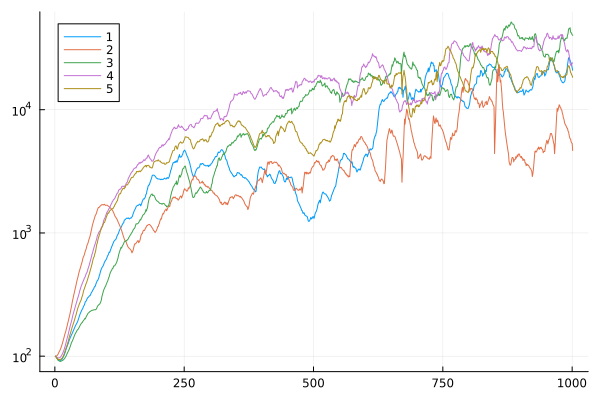

In [6]:
plot(firms[1].stockPriceLog.*firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog.*firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog.*firms[5].stockQuantityLog, label=string(5), yscale=:log10)

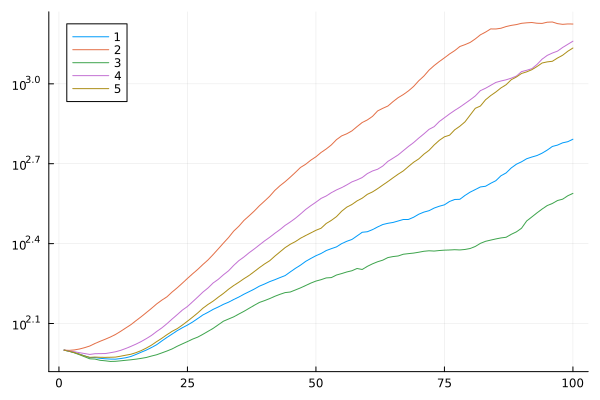

In [7]:
plot(firms[1].stockPriceLog[1:100].*firms[1].stockQuantityLog[1:100], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100].*firms[i].stockQuantityLog[1:100], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100].*firms[5].stockQuantityLog[1:100], label=string(5), yscale=:log10)

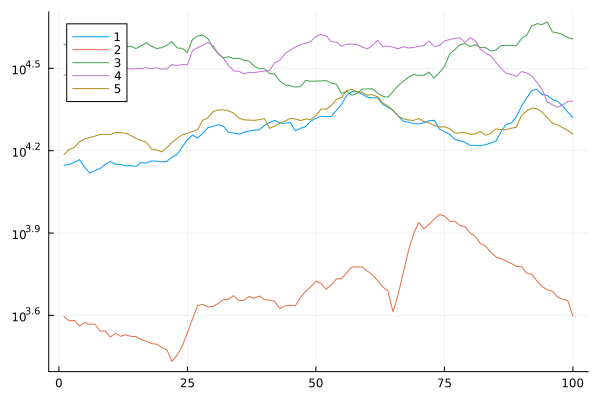

In [8]:
plot(firms[1].stockPriceLog[end-99:end].*firms[1].stockQuantityLog[end-99:end], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end].*firms[1].stockQuantityLog[end-99:end], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end].*firms[1].stockQuantityLog[end-99:end], label=string(5), yscale=:log10)

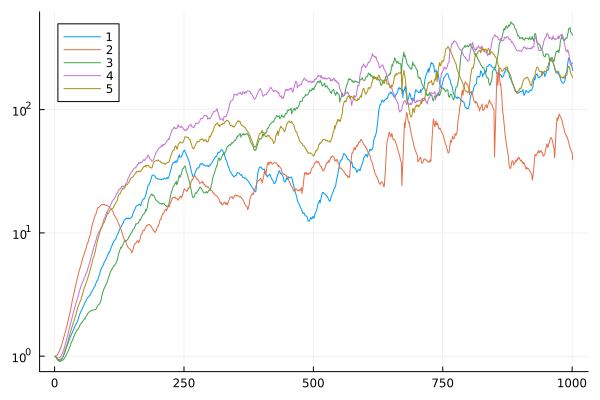

In [9]:
plot(firms[1].stockPriceLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog, label=string(5), yscale=:log10)

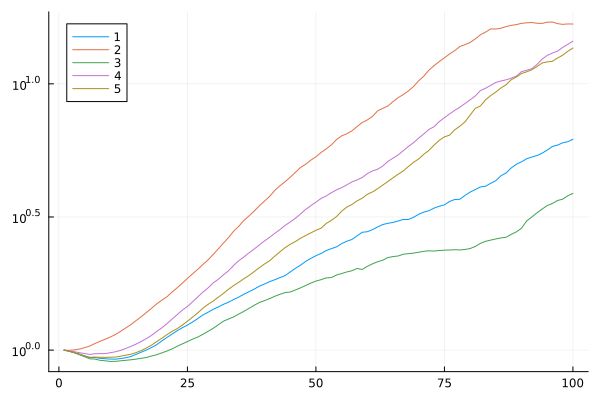

In [10]:
plot(firms[1].stockPriceLog[1:100], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[1:100], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[1:100], label=string(5), yscale=:log10)

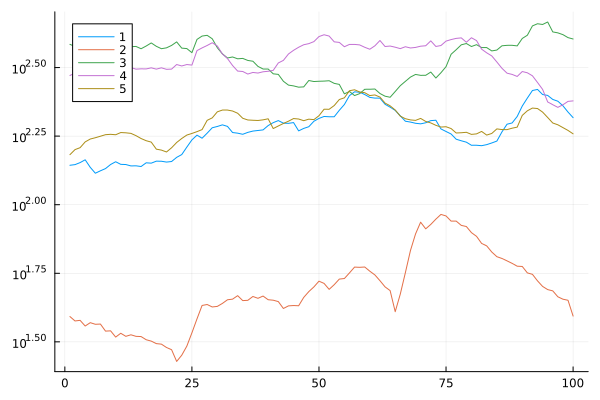

In [11]:
plot(firms[1].stockPriceLog[end-99:end], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockPriceLog[end-99:end], label=string(i), yscale=:log10)
end
plot!(firms[5].stockPriceLog[end-99:end], label=string(5), yscale=:log10)

・企業価値/時価総額が相対的に大きいときは、fundamental戦略をとるエージェントが売買の中心になっていて、価格変動が安定しやすい

・企業価値/時価総額が相対的に小さいときは、chart戦略をとるエージェントが売買の中心になっていて、価格変動が変動しやすい

かもしれない

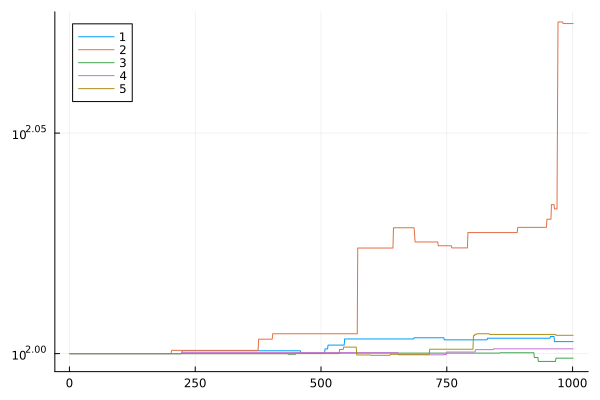

In [12]:
plot(firms[1].stockQuantityLog, label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockQuantityLog, label=string(i), yscale=:log10)
end
plot!(firms[5].stockQuantityLog, label=string(5), yscale=:log10)

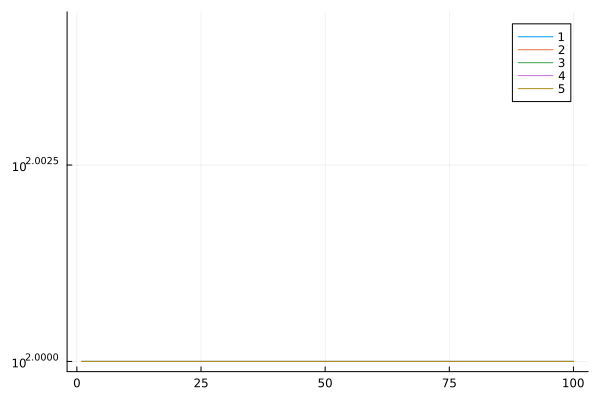

In [13]:
plot(firms[1].stockQuantityLog[1:100], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockQuantityLog[1:100], label=string(i), yscale=:log10)
end
plot!(firms[5].stockQuantityLog[1:100], label=string(5), yscale=:log10)

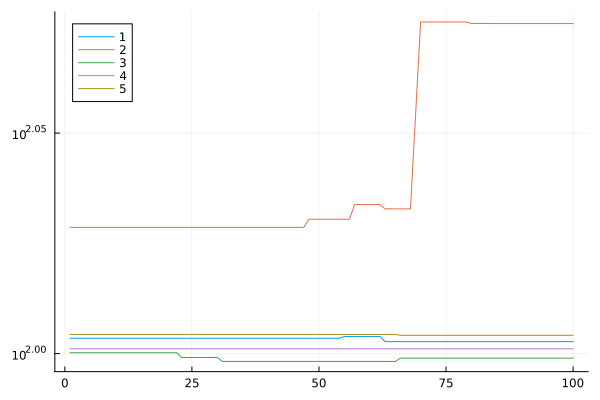

In [14]:
plot(firms[1].stockQuantityLog[end-99:end], label="1", yscale=:log10)
for i = 2:4
    plot!(firms[i].stockQuantityLog[end-99:end], label=string(i), yscale=:log10)
end
plot!(firms[5].stockQuantityLog[end-99:end], label=string(5), yscale=:log10)

In [15]:
firms[4].sell_offers

21652-element Vector{Any}:
 (2895.752756257815, 0.0011683964130130876, 69058)
 (2794.2521150978428, 0.00011376493263910684, 7308)
 (2761.4542047611826, 0.00015170257818832855, 81109)
 (2693.221466750622, 0.00020001811174255498, 97853)
 (2444.1346332659814, 0.0005826377573813313, 86645)
 (2438.8922289571847, 4.9413120733773954e-5, 33281)
 (2425.960476510359, 0.0004926739236708039, 51614)
 (2423.389637160366, 2.8656002365256843e-5, 4016)
 (2403.884883528543, 0.0001256024978304842, 38925)
 (2402.3019428249117, 0.00026813112083520584, 41988)
 (2387.1062738304117, 1.8773583994409676e-5, 83759)
 (2373.6909114351392, 0.0003917930515804812, 14144)
 (2360.016334979609, 0.0005303769337956556, 13230)
 ⋮
 (240.06858855559722, 0.00042827013702364625, 23510)
 (240.05172020208113, 0.00016469666644163008, 93927)
 (239.8061127542437, 0.0010510604226285638, 76260)
 (239.71188225260045, 0.0014040142574156622, 72450)
 (239.69525099383557, 1.484171094901411e-5, 33033)
 (239.5247889103782, 2.481443112916467

In [16]:
firms[4].buy_offers

866-element Vector{Any}:
 (140.91910670244087, 2.604822181169331e-5, 92876)
 (146.21799702944213, 0.005741383770489684, 12139)
 (157.6650600236064, 2.7124930803484463e-5, 90206)
 (159.4845812955382, 1.0519944514770436e-5, 96176)
 (161.621817323152, 4.72810425949918e-5, 40668)
 (163.66797553003704, 0.0016043830800682095, 51797)
 (165.74677501519105, 9.702386050252564e-5, 47131)
 (166.61382715948005, 4.601051670082637e-7, 81639)
 (166.65803825449692, 3.7239454918768136e-5, 42404)
 (167.4096139132099, 0.0005013796395616428, 63767)
 (168.33598204002976, 1.5989994909510803e-5, 67452)
 (168.46408923031012, 0.00011704015265260207, 24701)
 (168.97052298264038, 0.0001417674237904772, 412)
 ⋮
 (238.68843017958423, 5.830496817482805e-7, 55050)
 (238.6972654650618, 5.614818032823198e-5, 16043)
 (238.71304893673005, 0.006887765473834864, 39562)
 (238.76724291703871, 0.0006952029314249853, 93143)
 (238.77268739543197, 1.2638914090750561e-5, 82570)
 (238.77975372187612, 6.261103844279127e-5, 16155)
 

In [17]:
firms[4].stockPrice

239.03052566816712

In [18]:
tmp = 0.0
for i = 1:10
    for t = 1:99
        tmp += 100*(firms[i].stockPriceLog[end-t] - firms[i].stockPriceLog[end-1-t])/firms[i].stockPriceLog[end-1-t]
    end
    tmp /= 99
    println("「会社$i","の直近１００期の株価の平均変動率」は $tmp"," %")
end

「会社1の直近１００期の株価の平均変動率」は 0.5009493719918049 %
「会社2の直近１００期の株価の平均変動率」は 0.3201802568807351 %
「会社3の直近１００期の株価の平均変動率」は 0.1263411747497549 %
「会社4の直近１００期の株価の平均変動率」は -0.17423658518571983 %
「会社5の直近１００期の株価の平均変動率」は 0.2772001450432408 %
「会社6の直近１００期の株価の平均変動率」は 0.8347696537212563 %
「会社7の直近１００期の株価の平均変動率」は 0.13046486902113294 %
「会社8の直近１００期の株価の平均変動率」は -0.17162415963878608 %
「会社9の直近１００期の株価の平均変動率」は 0.29700192859513436 %
「会社10の直近１００期の株価の平均変動率」は 0.3647427242003878 %


In [19]:
for i = 1:10
    println(agents[i].portfolio_target[2], " / ", sum(agents[i].sharesRetainedLine))
end#    ポートフォリオ配分が目標との乖離が激しい問題。

1.188518474649207 / 4.282811507133509
0.529379673725307 / 0.6960500280973292
0.06862243688717382 / 0.11402250079449555
0.5912269298085107 / 0.0
0.0708110930624057 / 0.10173325103656171
0.36009627510786635 / 0.0
0.3976469023177395 / 0.0
0.007917735016287666

 / 0.0
0.0002330702128009935 / 0.0
0.11314001839197237 / 0.0


In [20]:
agents

100000-element Vector{Agent}:
 Agent("fundamentals", 3.4608439134590254, [0.00789001023190712, 0.0, 0.0021538237347419856, 0.0023253476241634715, 0.006057473136994117, 0.0, 0.0, 0.0, 0.0, 0.0007014496846657604], [1.6383278428453165, 0.0, 0.8655535737468315, 0.555829064965018, 1.0982162753245244, 0.0, 0.0, 0.0, 0.0, 0.12488475025181865], [0.09999999999999999, 0.10437985949040011, 0.1087024640588735, 0.11296234205184391, 0.11715468510818108, 0.12141849389681006, 0.12624825966545988, 0.13153306332201695, 0.13659549727471618, 0.14179383066948953  …  8.489921247762958, 8.697351153617529, 8.693338436574676, 8.523854209647682, 8.40790509323326, 8.174428675203478, 8.098212801020683, 7.99814382799916, 7.867139992186578, 7.743637420592535], [0.8465167711121652, 6.0], [124.44246398136512, 4957.963383197576, 389.1619947177229, 495.94815479891537, 86.18599483628985, 2.542677130459658, 20.433214716640872, 377.00986365196485, 7.788358973080287, 951.5561815343202], [6.5551189459433274, 1.1885184746492

In [21]:
firms[1].buy_offers

1345-element Vector{Any}:
 (120.55896301877203, 2.7937805729696654e-5, 92876)
 (122.90921637113702, 0.006267246722666674, 12139)
 (133.91524089681658, 0.00037233371870813595, 23371)
 (139.4550148018149, 0.00012973343456263147, 24701)
 (142.2835505397903, 0.0002165160858800585, 56592)
 (142.6503969116045, 0.0008058312254804261, 12938)
 (143.3326510913691, 4.907573933347942e-7, 81639)
 (147.2085931538265, 1.6777836353592307e-5, 67452)
 (148.32402153172222, 0.0025018054231828696, 49873)
 (148.5896130862244, 0.00045633918890003884, 53362)
 (148.90409333675026, 0.0002512558298551578, 62582)
 (149.05856136039273, 2.6326371656194937e-5, 90206)
 (149.2509966871923, 5.318029767600892e-5, 89755)
 ⋮
 (207.45064406726388, 3.9368468710321816e-5, 2889)
 (207.48276777558584, 0.00011812689578690792, 40131)
 (207.4898828413514, 0.00018009451198938624, 64545)
 (207.51812014314538, 5.3662979145065485e-5, 43849)
 (207.53308353595907, 2.7147580302142374e-5, 5197)
 (207.5417442347575, 3.478964605146964e-6, 

In [22]:
firms[1].sell_offers

12859-element Vector{Any}:
 (852.7339335929901, 0.00019628108533608995, 32234)
 (799.2906199736125, 0.010467935000424242, 67657)
 (771.1454077557394, 8.75783431007958e-5, 89569)
 (768.9074822439645, 0.00048105597777293324, 38482)
 (758.7184989172046, 0.0005090023226176746, 97256)
 (746.3162430350181, 0.0013797927793010117, 28959)
 (743.5436818680912, 4.72053136044377e-5, 47403)
 (730.4048173695403, 0.0018703465715975247, 64281)
 (699.0382205131419, 2.9518523867934127e-5, 72492)
 (686.482382805627, 0.0005685562677324021, 90903)
 (680.0633684932575, 6.890372233808267e-5, 96569)
 (668.6936778013649, 0.004034275966926095, 1371)
 (667.3917378318974, 0.0005744094907878655, 33759)
 ⋮
 (208.03500090869406, 0.022578667687685863, 17440)
 (208.00347694139336, 0.00011355243352789544, 32471)
 (207.94318637710333, 0.00044847405376434945, 82290)
 (207.92653562455624, 2.41926689072418e-6, 16610)
 (207.83555299078193, 1.4557713114611884e-5, 33896)
 (207.7401032579722, 2.9961470550133763e-5, 77715)
 (20

In [23]:
firms

10-element Vector{Firm}:
 Firm(207.64584514984983, 100.62679073106949, [1.0, 0.9901573529760848, 0.9790228405913051, 0.9659146480729726, 0.9515607391502068, 0.9376621971498745, 0.9376354415398611, 0.9316358304281416, 0.9278156815209742, 0.9255253850732887  …  244.74887670935263, 260.8058636731084, 263.15190643541484, 252.1539162772797, 250.27924447790633, 241.97194193378917, 238.38910373702936, 229.40342246030545, 217.63434816744072, 207.64584514984983], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0  …  100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949, 100.62679073106949], 20894.73500607, 126.20162913656867, Any[(120.55896301877203, 2.7937805729696654e-5, 92876), (122.90921637113702, 0.006267246722666674, 12139), (133.91524089681658, 0.00037233371870813595, 23371), (139.4550148018149, 0.00012973343456263147, 24701), (142.2835505397903

In [24]:
money_sum = 0.0
for agent in agents
    money_sum += agent.money
end
money_sum

625473.2295510502

In [25]:
for firm in firms[1:10]
    println(firm.hiddenCorporateValue)
end

126.20162913656867
7400.545515502105
337.07182384737973
635.0783988371071
103.06539781175667
3.958507410431062
20.54455996520477
491.9859850354877
12.643192390744568
1490.9111065776638


In [26]:
for firm in firms[1:10]
    println(firm.marketCapitalization)
end

20894.73500607
4665.396532377042
40091.99034636307
23962.87838943523
18303.860154597092
4094.6329014908056
3837.08310804109
25533.053811348014
2122.524252816068
18046.15236784128


In [27]:
mean_amp = 0.0
for firm in firms[1:10]
    println(firm.marketCapitalization/firm.hiddenCorporateValue)
    mean_amp += firm.marketCapitalization/firm.hiddenCorporateValue
end
mean_amp /= 10


165.56628586354327
0.6304125179156483
118.941980640055
37.732157845887514
177.59461995215983
1034.388085443781
186.76881444721883
51.897929184926426
167.87882262788779
12.104110223758154


195.35032187471333

In [28]:
for agent in agents[1:10]
    println(agent.fundamentals)
end

[124.44246398136512, 4957.963383197576, 389.1619947177229, 495.94815479891537, 86.18599483628985, 2.542677130459658, 20.433214716640872, 377.00986365196485, 7.788358973080287, 951.5561815343202]
[222.33715949428634, 4267.972449568174, 242.15899236686462, 430.1704011891707, 142.1779911355904, 2.1722997098801033, 24.626476381484455, 294.3416879279956, 11.672334622590506, 1512.7482908765298]
[96.44118725460108, 11759.410807225644, 308.74030716475977, 793.913357340809, 139.26075601796393, 2.838392566588421, 9.977435621824437, 446.56257454493345, 6.943173590909597, 1508.3091234513454]
[188.9848748675005, 7638.007254441552, 441.20275768934385, 493.1266244422684, 203.37285567211669, 2.2287250674126353, 16.106117250432717, 502.7091881156677, 8.146174309804668, 1609.9590064489723]
[285.70677624767444, 10280.27367788787, 409.220698494665, 702.8741802109722, 75.90172507483852, 5.174384250620218, 44.89279857263952, 414.5622911292233, 9.066184031884253, 2145.154785858194]
[159.31718659117865, 10225

In [29]:
for agent in agents[1:10]
    println(agent.params)
end

[0.8465167711121652, 6.0]
[0.5965793633926919, 9.0]
[0.5537132997131176, 1.0, 0.4557621233289092, 0.4722947318110783, -0.22268610103348732, -0.5409080155353719, -0.16446273857112817, 0.025611750953246915, -0.034694691749214995, 0.02118467926187162, 0.41694718995220476, 9.0]


[0.7020886514463865, 21.0]
[0.9772924900811405, 1.0, -0.6463537501906422, 0.5919556680865701, 0.07237501779322102, -0.12391363550971277, 0.10593669982056389, 0.18164841970842804, -0.006346759725558634, 0.06546792359904924, 0.5019843410289218, 8.0]
[0.7502549970642239, 2.0]
[0.8943080160164321, 2.0, 0.4008598689027757, 0.4722590864933089, 0.03550229007132576, -0.4876724592394511, -0.4209487862279593, -0.0841563812369986, -0.062032928826172146, 0.15456223284034853, 0.632478994192482, 14.0]
[0.9846029748817338, 1.0, 0.11690097315617562, 0.6847659452752942, -0.16997542168321486, -0.1048705778469301, -0.5268209189013248, -0.04215539976495507, 0.025897570576286066, 0.11666567879978136, 0.9893809093106072, 7.0]
[0.9994925990009897, 5.0]
[0.855335207931348, 6.0]


In [30]:
for agent in agents[1:10]
    println(agent.sharesQuantity)
end

[0.00789001023190712, 0.0, 0.0021538237347419856, 0.0023253476241634715, 0.006057473136994117, 0.0, 0.0, 0.0, 0.0, 0.0007014496846657604]
[0.0006152155634113893, 0.00010325986582042222, 0.0003809425787889237, 0.00046126425628926186, 0.0006796077255313351, 0.0003628057859082166, 0.0, 0.000662516365852232, 0.0, 5.736821116771873e-5]
[0.0, 0.0, 0.0, 0.0002639123421906153, 0.0, 0.0017579239170300036, 0.0, 2.2902062848677145e-5, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.0915764835547445e-5, 0.00012709733302920513, 4.145588666395574e-5, 0.00010995901694752831, 9.348403797247834e-5, 0.0, 1.8717258307825352e-5, 0.00011577159110550702, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
